In [1]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, fig4_plotting_colours
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.plotting import output_significance_stars_from_pval
import statsmodels.api as sm

In [2]:
def perform_single_lag_regression(all_session_data, lag):
    all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
    all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
    all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])
    all_session_data[f'choice_t_minus{lag}_match'] = (all_session_data[f'choice_t_minus_{lag}'] == all_session_data['choice'])
    all_session_data[f'turn_ang_t_minus_{lag}'] = shift_respecting_index(all_session_data['turn angle'], lag)

    test_var = f'turn_ang_t_minus_{lag}'


    contra_trials = all_session_data[(all_session_data['trial_type'].notna())
                                     & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                     & (all_session_data[f'choice_t_minus{lag}_match'] == True)
                                    & (all_session_data['First choice correct'] == 1)]
    df = contra_trials[['APE_peaks', test_var]].copy()
    df.loc[:, test_var] = df[test_var].astype(float)
    df.loc[:, 'APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

    df.loc[:, 'APE_peaks'] = df['APE_peaks'].astype(float)
    df = df.dropna().reset_index(drop=True)


    y = df[test_var]
    X = df['APE_peaks'].astype(float)
    X = sm.add_constant(X)
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    return model.params[1:], model.pvalues[1:]

In [3]:
def shift_respecting_index(vals_to_shift, shift_size):
    """
    Shifts a pandas df column by shift_size indices
    but if there is a discontinuity in the index,
    replaces the shifted index with nan
    """
    
    shifted_vals = vals_to_shift.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = vals_to_shift.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > np.abs(shift_size)
    shifted_vals[discontinuities] = np.nan

    return shifted_vals


In [4]:
def get_session_with_10000th_trial(mouse, experiments):
    dates = experiments[experiments['mouse_id']==mouse]['date'].unique()
    session_starts = get_bpod_trial_nums_per_session(mouse, dates)
    if session_starts[-1] >= 10000:
        last_session_idx = np.where(np.asarray(session_starts) >=10000)[0][0]
        print(np.asarray(session_starts) >=10000)
    else:
        last_session_idx = -1
        print(session_starts[-1])
    last_session_date = dates[last_session_idx]
    return(last_session_date)

In [5]:
def get_movement_data(mouse, all_experiments):
    all_experiments = remove_exps_after_manipulations(all_experiments, [mouse])
    all_experiments = remove_manipulation_days(all_experiments)
    all_experiments = remove_unsuitable_recordings(all_experiments)
    experiments_to_process = all_experiments[
        (all_experiments['mouse_id'] == mouse) & (all_experiments['recording_site'] == recording_site)]
    last_session = get_session_with_10000th_trial(mouse, experiments_to_process)
    dates = experiments_to_process['date'].values
    last_session_ind = int(np.where(dates == last_session)[0])
    for i, date in enumerate(dates[0: last_session_ind + 1]):
        save_out_folder = os.path.join(raw_tracking_path, mouse, date)
        movement_param_file = os.path.join(save_out_folder, 'APE_tracking{}_{}.pkl'.format(mouse, date))
        if os.path.isfile(movement_param_file):
            session_data = pd.read_pickle(movement_param_file)
            session_data['date'] = date
            session_data.mouse = mouse
            print(date, session_data.shape)
            if i == 0:
                all_session_data = session_data
            else:
                all_session_data = pd.concat([all_session_data, session_data])
        else:
            print('{} not found'.format(date))
    all_session_data = all_session_data.reset_index(drop=True)
    all_session_data['abs fitted max cumsum ang vel'] = all_session_data['fitted max cumsum ang vel'].abs()
    return all_session_data                                              

In [6]:
recording_site = 'tail'
all_experiments = get_all_experimental_records()

In [7]:
mice = change_over_time_mice[recording_site]
num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
pvals = np.zeros([num_mice, num_lags])

for m, mouse in enumerate(mice):
    movement_data = get_movement_data(mouse, all_experiments)
    movement_data = movement_data.set_index('actual trial numbers')
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    no_movement_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')


    # Get the common and all indices between the two dataframes
    common_indices = movement_data.index.intersection(no_movement_data.index)
    no_movement_data.loc[common_indices,'turn angle'] = movement_data.loc[common_indices,'abs fitted max cumsum ang vel']
    with_movement_data = no_movement_data.copy()
    contra_side = with_movement_data[(with_movement_data['trial_type'] == 'contra_data') & (with_movement_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'}
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    with_movement_data['choice'] = with_movement_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    with_movement_data['choice'] = with_movement_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        coefs[m, lag-1], pvals[m, lag-1] = perform_single_lag_regression(with_movement_data, -lag)


[False False False False False False False False  True  True  True]
20200210 (301, 50)
20200213 (281, 50)
20200218 (282, 50)
20200220 (367, 50)
20200224 (286, 50)
20200227 (266, 50)
20200303 (303, 50)
20200305 (291, 50)
20200307 (292, 50)
[False False False False False False False False False False False False
 False False  True]
20200204 (145, 50)
20200206 (208, 50)
20200208 (439, 50)
20200210 (246, 50)
20200212 (222, 50)
20200214 (265, 50)
20200218 (358, 50)
20200221 (289, 50)
20200224 (238, 50)
20200226 (267, 50)
20200228 (251, 50)
20200303 (298, 50)
20200305 (279, 50)
20200307 (304, 50)
20200310 (278, 50)
8071
20200223 (87, 50)
20200226 (267, 50)
20200228 (273, 50)
20200229 (344, 50)
20200303 (315, 50)
20200305 (293, 50)
20200307 (306, 50)
20200310 (341, 50)
20200312 (245, 50)
20200313 (278, 50)
20200316 (278, 50)
removing SNL_photo21: ['20200829' '20200830' '20200831' '20200908' '20200915' '20201008'
 '20201009']
7929
20200806 (208, 50)
20200808 (355, 50)
20200810 (355, 50)
202008

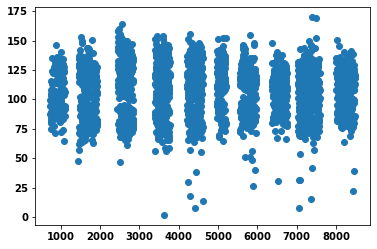

In [8]:
plt.scatter(no_movement_data.index.values, no_movement_data['turn angle'].values)

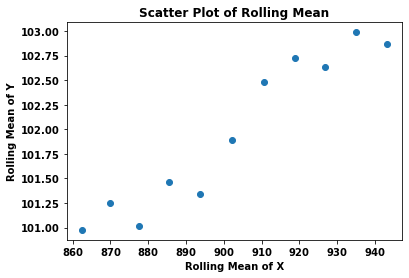

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_for_reg['APE_peaks'] is your data
no_nan_movement_data = no_movement_data[no_movement_data['trial_type'] == 'ipsi_data'].dropna()
x_values = no_nan_movement_data['turn angle'].index.values
y_values = no_nan_movement_data['turn angle'].values

# Convert x_values to a Pandas Series to calculate the rolling mean
x_series = pd.Series(x_values)
y_series = pd.Series(y_values)

# Calculate the rolling mean with a window size of your choice, e.g., 5
rolling_x = x_series.rolling(window=40).mean()
rolling_y = y_series.rolling(window=40).mean()

# Create a scatter plot using the rolling means
plt.scatter(rolling_x, rolling_y)
plt.title('Scatter Plot of Rolling Mean')
plt.xlabel('Rolling Mean of X')
plt.ylabel('Rolling Mean of Y')
plt.show()


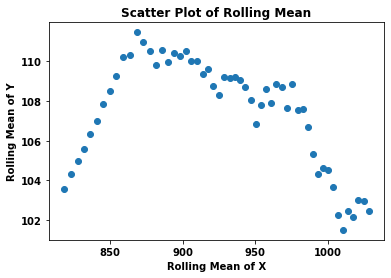

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_for_reg['APE_peaks'] is your data
no_nan_movement_data = no_movement_data[no_movement_data['trial_type'] == 'contra_data'].dropna()
x_values = no_nan_movement_data['turn angle'].index.values
y_values = no_nan_movement_data['turn angle'].values

# Convert x_values to a Pandas Series to calculate the rolling mean
x_series = pd.Series(x_values)
y_series = pd.Series(y_values)

# Calculate the rolling mean with a window size of your choice, e.g., 5
rolling_x = x_series.rolling(window=40).mean()
rolling_y = y_series.rolling(window=40).mean()

# Create a scatter plot using the rolling means
plt.scatter(rolling_x, rolling_y)
plt.title('Scatter Plot of Rolling Mean')
plt.xlabel('Rolling Mean of X')
plt.ylabel('Rolling Mean of Y')
plt.show()


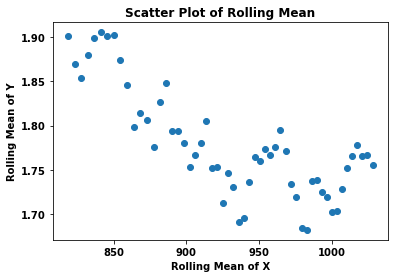

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_for_reg['APE_peaks'] is your data
no_nan_movement_data = no_movement_data[no_movement_data['trial_type'] == 'contra_data'].dropna()
x_values = no_nan_movement_data['APE_peaks'].index.values
y_values = no_nan_movement_data['APE_peaks'].values

# Convert x_values to a Pandas Series to calculate the rolling mean
x_series = pd.Series(x_values)
y_series = pd.Series(y_values)

# Calculate the rolling mean with a window size of your choice, e.g., 5
rolling_x = x_series.rolling(window=40).mean()
rolling_y = y_series.rolling(window=40).mean()

# Create a scatter plot using the rolling means
plt.scatter(rolling_x, rolling_y)
plt.title('Scatter Plot of Rolling Mean')
plt.xlabel('Rolling Mean of X')
plt.ylabel('Rolling Mean of Y')
plt.show()

In [12]:
coefs

array([[-0.81697738,  0.55700903, -3.06792222, -1.86733853, -1.45088513],
       [-1.1609504 , -1.96690948, -2.51318002, -1.5704686 , -1.54612227],
       [-0.50965599,  1.10184912,  1.0290643 ,  2.72646293, -0.8470877 ],
       [ 0.88622049,  0.1119156 ,  1.08132468,  1.21072054,  0.30122197],
       [-1.58551561, -1.60074724, -2.45562036, -2.31818467, -1.56585523],
       [-2.64552444, -2.02207588, -2.21102338, -2.47613912, -3.16083733]])

In [13]:
pvals

array([[2.74202755e-01, 5.76698377e-01, 1.71613522e-03, 3.67466135e-02,
        1.14498402e-01],
       [2.60599945e-02, 7.55796456e-03, 4.19442373e-04, 3.49880039e-02,
        3.27527229e-02],
       [6.14071972e-01, 3.30687205e-01, 3.67465649e-01, 2.46365745e-02,
        5.32340110e-01],
       [1.89081303e-01, 8.75114154e-01, 1.44838967e-01, 9.19621626e-02,
        6.75308456e-01],
       [7.69980081e-03, 2.25341979e-02, 5.47791973e-04, 1.62226880e-03,
        3.23673843e-02],
       [2.80537829e-07, 6.38738576e-03, 1.69843274e-03, 1.01710992e-03,
        1.60553068e-05]])

In [14]:
def plot_multilag_coefs_accross_mice(recording_site, coefs, axs, color='blue'):
    # Calculate the mean and SEM across axis=0
    mean_coefs = np.mean(coefs, axis=0)
    sem_coefs = stats.sem(coefs, axis=0)

    # Create the x-axis values
    x = (np.arange(mean_coefs.shape[0]) + 1).astype(int)

    # Plot the mean
    axs.plot(x, mean_coefs, label=recording_site, color=color)


    # Plot the shaded error bars using SEM
    axs.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color=color, alpha=0.3, label='')
    plot_sig_stars_multilag(coefs, color, axs)
    # Adding labels and legend
    axs.set_ylabel('Regression coef')
    axs.set_xlabel('Number of trials back')
    #axs.set_ylim([-0.01, 0.01])
    plt.legend(frameon=False)

In [15]:
def plot_sig_stars_multilag(coefs, color, axs):
    second_order_coefs, second_order_pvals = test_for_coef_trend_against_zero_mulit_lag(coefs)
    for lag_num in range(0, len(second_order_coefs)):
        sig_stars = output_significance_stars_from_pval(second_order_pvals[lag_num])
        if sig_stars != 'n.s.':
            if second_order_coefs[lag_num] >= 0:
                y = 0.01
            else:
                y=-0.01
            axs.text(lag_num + 1, y, sig_stars, ha='center', fontsize=12, color=color)
            

In [16]:
def test_for_coef_trend_against_zero_mulit_lag(coefs):
    pvals = []
    slopes = []
    for lag_num in range(0, coefs.shape[1]):
        test = stats.ttest_1samp(coefs.T[lag_num], 0)
        pvals.append(test.pvalue)
        slopes.append(test.statistic)
    return slopes, pvals

[0.09856543118323857]
[0.09856543118323857, 0.3121964768724884]
[0.09856543118323857, 0.3121964768724884, 0.13894497012772986]
[0.09856543118323857, 0.3121964768724884, 0.13894497012772986, 0.45341850652953286]
[0.09856543118323857, 0.3121964768724884, 0.13894497012772986, 0.45341850652953286, 0.0302387632179717]


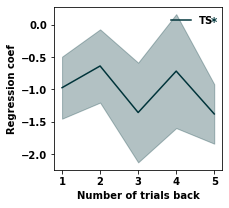

In [17]:
fig, axs = plt.subplots(1,1, figsize=[3,3])
plot_multilag_coefs_accross_mice('TS', coefs, axs, color=fig4_plotting_colours[recording_site][0])